## This notebook is used for datasets processing and DeepForest model testing.

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q DeepForest
!pip install -q rasterio matplotlib
!pip install -q rpy2

In [2]:
%load_ext rpy2.ipython

Downloading the NEON dataset

In [ ]:
%%R
library(devtools)
devtools::install_github("Weecology/NeonTreeEvaluation_package")
library(NeonTreeEvaluation)
ls("package:NeonTreeEvaluation")

In [ ]:
%%R
download()

Parsing XML annotations and saving to CSV

In [5]:
import os
import csv
import xml.etree.ElementTree as ET

image_dir = '/usr/local/lib/R/site-library/NeonTreeEvaluation/extdata/NeonTreeEvaluation/evaluation/RGB/'
xml_dir = '/usr/local/lib/R/site-library/NeonTreeEvaluation/extdata/NeonTreeEvaluation/annotations/'
output_csv = "annotations.csv"

# Getting lists of files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
xml_files = [f for f in os.listdir(xml_dir) if f.endswith('.xml')]

# Extracting base filenames
image_basenames = {os.path.splitext(f)[0]: f for f in image_files}
xml_basenames = {os.path.splitext(f)[0]: f for f in xml_files}

# Matching files
matching_files = image_basenames.keys() & xml_basenames.keys()

# Function to parse XML
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes

# Creating CSV file
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write headers
    writer.writerow(["image_path", "xmin", "ymin", "xmax", "ymax", "label"])

    # Processing matching files
    for basename in matching_files:
        image_path = os.path.join(image_dir, image_basenames[basename])
        xml_path = os.path.join(xml_dir, xml_basenames[basename])

        # Parsing annotations
        boxes = parse_xml(xml_path)

        # Writing annotations to CSV
        for box in boxes:
            writer.writerow([image_path, box[0], box[1], box[2], box[3], "Tree"])

print(f"CSV file saved: {output_csv}")


CSV file saved: annotations.csv


Image augmentation and annotation update

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

annotations_csv = "annotations.csv"  # CSV file with annotations
output_dir = os.path.join(os.getcwd(), "output_neon")  # Directory for saving data
augmented_dir = os.path.join(output_dir, "augmented_images")  # Folder for augmented images
os.makedirs(output_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

# Function for image augmentation
def augment_image(image_path, output_dir, augment_count=6):

    base_name = os.path.basename(image_path)
    name, ext = os.path.splitext(base_name)

    with Image.open(image_path) as image:
        augmented_paths = []
        width, height = image.size

        for i in range(augment_count):
            # Applying different types of augmentation
            aug_image = image.copy()

            if i == 0:
                aug_image = aug_image.transpose(Image.FLIP_LEFT_RIGHT)  # Horizontal flip
                transform_type = "flip_lr"
            elif i == 1:
                enhancer = ImageEnhance.Contrast(aug_image)  # Contrast adjustment
                aug_image = enhancer.enhance(1.5)  # Increase contrast
                transform_type = "increase_contrast"
            elif i == 2:
                enhancer = ImageEnhance.Brightness(aug_image)  # Brightness adjustment
                aug_image = enhancer.enhance(1.2)  # Increase brightness
                transform_type = "brightness_increase"
            elif i == 3:
                enhancer = ImageEnhance.Brightness(aug_image)  # Brightness adjustment
                aug_image = enhancer.enhance(0.8)  # Decrease brightness
                transform_type = "brightness_decrease"
            elif i == 4:
                enhancer = ImageEnhance.Contrast(aug_image)  # Contrast adjustment
                aug_image = enhancer.enhance(0.8)  # Decrease contrast
                transform_type = "decrease_contrast"
            elif i == 5:
                aug_image = aug_image.transpose(Image.FLIP_TOP_BOTTOM)  # Vertical flip
                transform_type = "flip_tb"

            # Saving augmented image
            aug_path = os.path.join(output_dir, f"{name}_aug{i}{ext}")
            aug_image.save(aug_path)
            augmented_paths.append((aug_path, transform_type, width, height))

    return augmented_paths

# Function for adjusting annotations
def adjust_annotations(image_annotations, transform_type, image_width, image_height):
    updated_annotations = []
    for _, row in image_annotations.iterrows():
        x_min, y_min, x_max, y_max = row["xmin"], row["ymin"], row["xmax"], row["ymax"]

        if transform_type == "flip_lr":
            # Horizontal flip
            x_min, x_max = image_width - x_max, image_width - x_min
        elif transform_type == "flip_tb":
            # Vertical flip
            y_min, y_max = image_height - y_max, image_height - y_min

        # Adding updated row to list
        updated_annotations.append({
            "image_path": row["image_path"],
            "xmin": x_min,
            "ymin": y_min,
            "xmax": x_max,
            "ymax": y_max,
            "label": row["label"]
        })

    return pd.DataFrame(updated_annotations)

annotations = pd.read_csv(annotations_csv)

# Splitting into training and validation sets
image_paths = annotations["image_path"].unique()

np.random.seed(42)
valid_paths = np.random.choice(image_paths, int(len(image_paths) * 0.25), replace=False)

valid_annotations = annotations[annotations["image_path"].isin(valid_paths)]
train_annotations = annotations[~annotations["image_path"].isin(valid_paths)]

# List for new augmented annotations
augmented_annotations = []

# Getting training image paths
train_paths = train_annotations["image_path"].unique()

# Augment only training images
for image_path in train_paths:
    # Finding annotations for the current image
    image_annotations = train_annotations[train_annotations["image_path"] == image_path]

    # Creatung augmented copies of the image
    augmented_data = augment_image(image_path, augmented_dir)

    # Creating annotations for augmented images
    for aug_path, transform_type, width, height in augmented_data:
        if transform_type:
            aug_annots = adjust_annotations(image_annotations, transform_type, width, height)
        else:
            aug_annots = image_annotations.copy()

        aug_annots["image_path"] = aug_path
        augmented_annotations.append(aug_annots)

# Adding augmented annotations to the original
if augmented_annotations:
    augmented_annotations_df = pd.concat(augmented_annotations, ignore_index=True)
    train_annotations = pd.concat([train_annotations, augmented_annotations_df], ignore_index=True)

train_csv_NEON = os.path.join(output_dir, "train_NEON.csv")
valid_csv_NEON = os.path.join(output_dir, "valid_NEON.csv")
train_annotations.to_csv(train_csv_NEON, index=False)
valid_annotations.to_csv(valid_csv_NEON, index=False)


Displaying augmented images with annotations

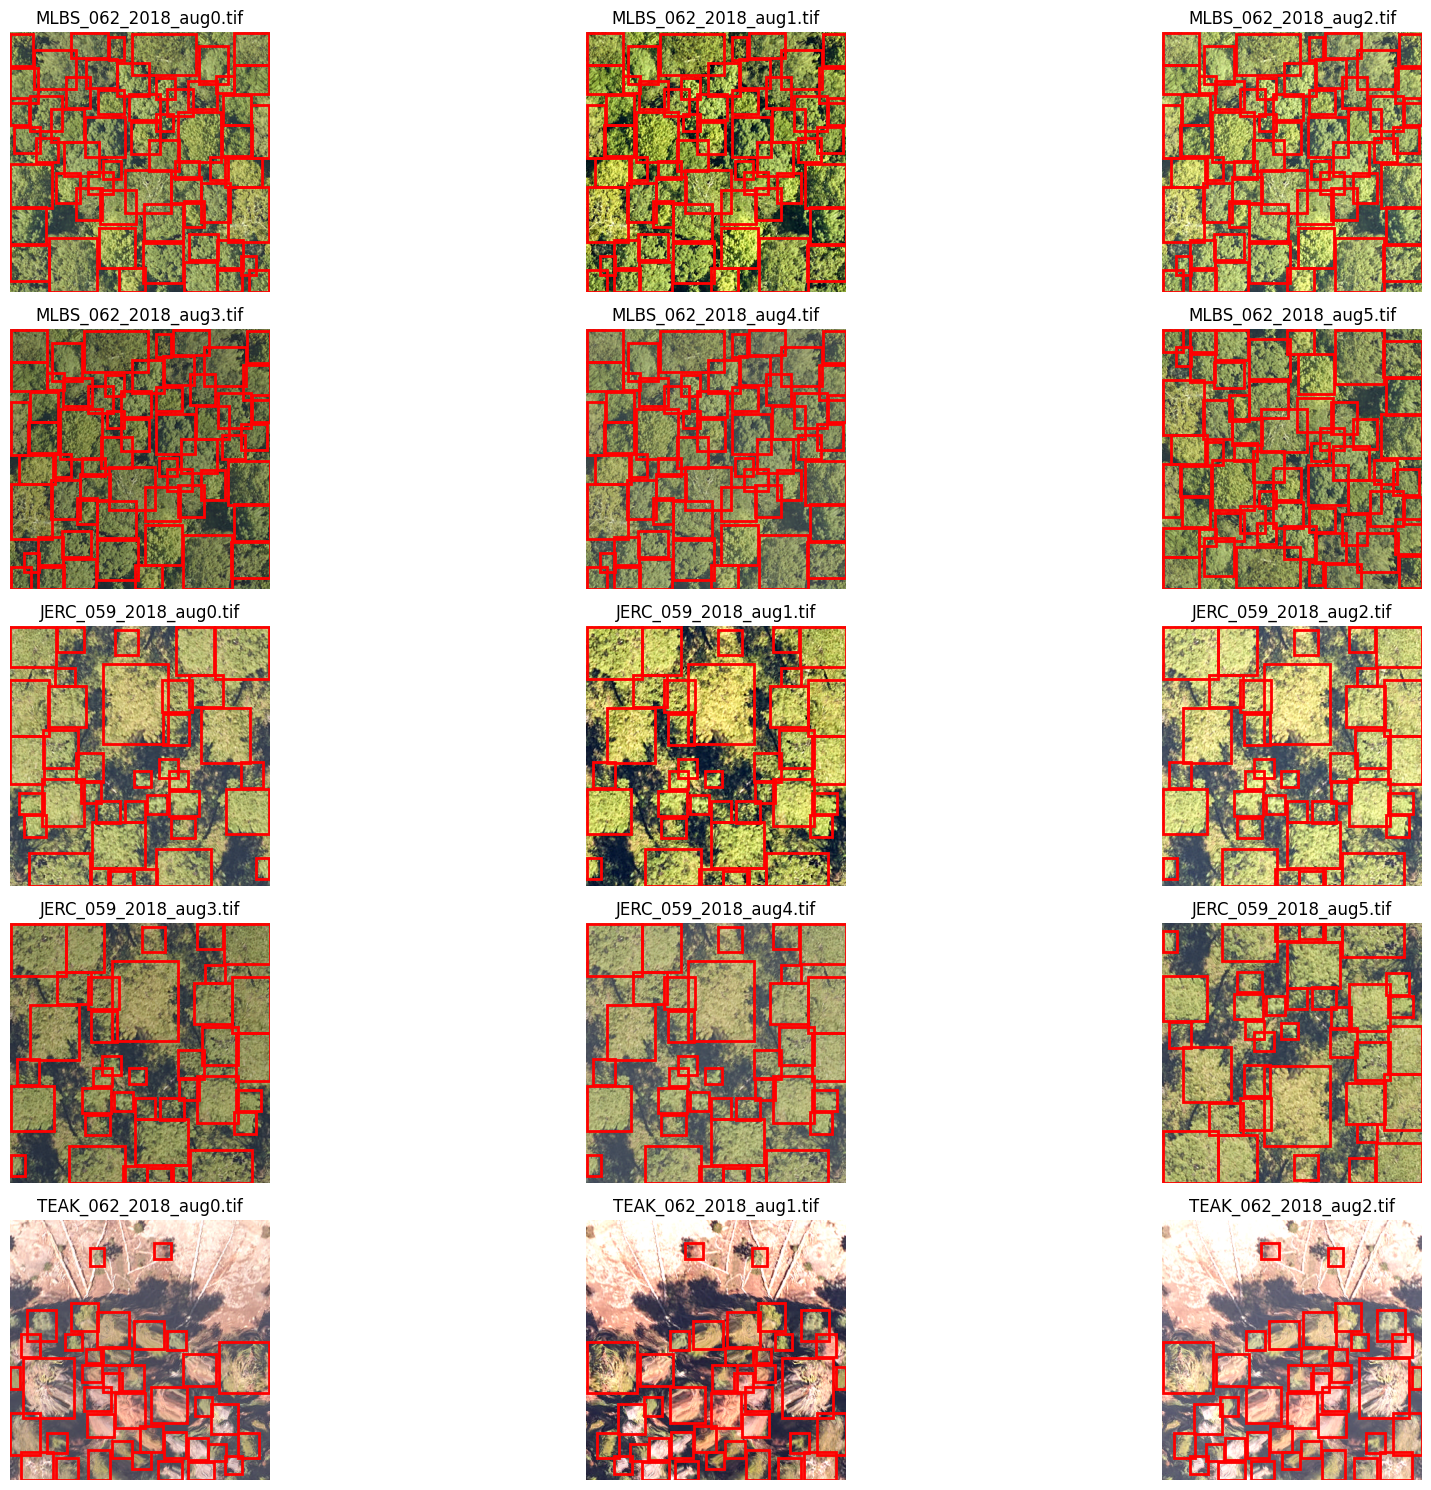

In [7]:
# Filtering only augmented images
augmented_images = train_annotations[train_annotations["image_path"].str.contains("_aug")]["image_path"].unique()

# Selecting augmented images
sample_augmented_images = augmented_images[:15]

# Function to display images with annotations
def show_image_with_annotations(image_path, annotations):
    """Displays an image with bounding box annotations."""
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')

    for _, row in annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        # Drawing a rectangle around the annotated object
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          linewidth=2, edgecolor='r', facecolor='none'))

    plt.title(os.path.basename(image_path))

plt.figure(figsize=(20, 15))

for i, img_path in enumerate(sample_augmented_images):

    image_annotations = train_annotations[train_annotations['image_path'] == img_path]
    plt.subplot(5, 3, i + 1)
    show_image_with_annotations(img_path, image_annotations)

plt.tight_layout()
plt.show()


In [8]:
# Checking the number of rows in files after saving
train_annotations_loaded = pd.read_csv(train_csv_NEON)
valid_annotations_loaded = pd.read_csv(valid_csv_NEON)

print(f"Checking the number of annotations in {train_csv_NEON} after saving: {len(train_annotations_loaded)}")
print(f"Checking the number of annotations in {valid_csv_NEON} after saving: {len(valid_annotations_loaded)}")


Checking the number of annotations in /content/output_neon/train_NEON.csv after saving: 34706
Checking the number of annotations in /content/output_neon/valid_NEON.csv after saving: 1676


Merging NEON and LR datasets and splitting into training and validation sets.

In [9]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split

annotations_csv = "annotations.csv"  # CSV file containing annotations for NEON
additional_csv = "/content/updated_trees.csv"  # CSV containing annotations for new images (LR dataset)
additional_images_dir = "/content/myDS"  # Directory containing new images

output_dir = os.path.join(os.getcwd(), "output_neon+lr")  # Creating a directory for saving data
augmented_dir = os.path.join(output_dir, "augmented_images")  # Creating a folder for augmented images
os.makedirs(output_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

#  Loading annotations
annotations = pd.read_csv(annotations_csv)
additional_annotations = pd.read_csv(additional_csv)

# Merging additional annotations into the main dataset
annotations = pd.concat([annotations, additional_annotations], ignore_index=True)

# Splitting into training and validation datasets
image_paths = annotations["image_path"].unique()

np.random.seed(42)
valid_paths = np.random.choice(image_paths, int(len(image_paths) * 0.25), replace=False)

valid_annotations = annotations[annotations["image_path"].isin(valid_paths)]
train_annotations = annotations[~annotations["image_path"].isin(valid_paths)]

# Creating a list for new augmented annotations
augmented_annotations = []

# Retrieving paths of training images
train_paths = train_annotations["image_path"].unique()

# Performing augmentation only for training images
for image_path in train_paths:
    # Finding annotations for the current image
    image_annotations = train_annotations[train_annotations["image_path"] == image_path]

    # Generating augmented copies of the image
    augmented_data = augment_image(image_path, augmented_dir)

    # Creating annotations for augmented images
    for aug_path, transform_type, width, height in augmented_data:
        if transform_type:
            aug_annots = adjust_annotations(image_annotations, transform_type, width, height)
        else:
            aug_annots = image_annotations.copy()

        aug_annots["image_path"] = aug_path
        augmented_annotations.append(aug_annots)

# Adding augmented annotations to the original dataset
if augmented_annotations:
    augmented_annotations_df = pd.concat(augmented_annotations, ignore_index=True)
    train_annotations = pd.concat([train_annotations, augmented_annotations_df], ignore_index=True)

train_csv_NEON_LR = os.path.join(output_dir, "train_NEON+LR.csv")
valid_csv_NEON_LR = os.path.join(output_dir, "valid_NEON+LR.csv")
train_annotations.to_csv(train_csv_NEON_LR, index=False)
valid_annotations.to_csv(valid_csv_NEON_LR, index=False)


In [10]:
def print_statistics(file_path, description):
    annotations = pd.read_csv(file_path)
    num_annotations = len(annotations)
    num_images = annotations["image_path"].nunique()

    print(f"{description}:")
    print(f"  - Counting images: {num_images}")
    print(f"  - Counting annotations: {num_annotations}")
    print("-" * 50)

# Defining paths to the final files
train_csv_NEON_LR = "output_neon+lr/train_NEON+LR.csv"
valid_csv_NEON_LR = "output_neon+lr/valid_NEON+LR.csv"

print_statistics(train_csv_NEON_LR, "Training set")
print_statistics(valid_csv_NEON_LR, "Validation set")


Training set:
  - Counting images: 1155
  - Counting annotations: 41552
--------------------------------------------------
Validation set:
  - Counting images: 55
  - Counting annotations: 1727
--------------------------------------------------


Annotation extraction for LR and NEON datasets

In [11]:
import pandas as pd

valid_csv_NEON_path = "/content/output_neon+lr/valid_NEON+LR.csv"
train_csv_NEON_path = "/content/output_neon+lr/train_NEON+LR.csv"

# Defining the path to the annotation file from myDS
myDS_annotations_path = "/content/updated_trees.csv"

# Loading annotations from valid_csv_NEON, train_csv_NEON, and myDS
valid_annotations = pd.read_csv(valid_csv_NEON_path)
train_annotations = pd.read_csv(train_csv_NEON_path)
myDS_annotations = pd.read_csv(myDS_annotations_path)

# Getting a list of image paths from the myDS folder
myDS_image_paths = myDS_annotations["image_path"].unique()

# Filtering annotations from valid_csv_NEON for images from the myDS folder
filtered_annotations = valid_annotations[valid_annotations["image_path"].isin(myDS_image_paths)]

valid_lr_path = "valid_lr.csv"
filtered_annotations.to_csv(valid_lr_path, index=False)

# Filtering annotations for valid_neon_new.csv
remaining_annotations = valid_annotations[~valid_annotations["image_path"].isin(myDS_image_paths)]

# Saving the remaining annotations to valid_neon_new.csv
valid_neon_new_path = "valid_neon_new.csv"
remaining_annotations.to_csv(valid_neon_new_path, index=False)

# Filtering annotations for train_neon_new.csv
train_remaining_annotations = train_annotations[~train_annotations["image_path"].isin(myDS_image_paths)]

# Saving the remaining train annotations to train_neon_new.csv
train_neon_new_path = "train_neon_new.csv"
train_remaining_annotations.to_csv(train_neon_new_path, index=False)

print(f"Saving valid_lr annotations to {valid_lr_path}")
print(f"Saving valid_neon annotations to {valid_neon_new_path}")
print(f"Saving train_neon annotations to {train_neon_new_path}")


Saving valid_lr annotations to valid_lr.csv
Saving valid_neon annotations to valid_neon_new.csv
Saving train_neon annotations to train_neon_new.csv


In [12]:
print_statistics(valid_lr_path, "Validation set for the LR dataset")
print_statistics(valid_neon_new_path, "Validation set for the NEON dataset")
print_statistics(train_neon_new_path, "Training set for the NEON dataset")


Validation set for the LR dataset:
  - Counting images: 8
  - Counting annotations: 343
--------------------------------------------------
Validation set for the NEON dataset:
  - Counting images: 47
  - Counting annotations: 1384
--------------------------------------------------
Training set for the NEON dataset:
  - Counting images: 1137
  - Counting annotations: 40866
--------------------------------------------------


Testing the DeepForest model before training



In [13]:
import os
import pandas as pd
from deepforest import main
import time

model = main.deepforest()

# loading a pre-trained model
model.load_model(model_name="weecology/deepforest-tree", revision="main")

# evaluating the model
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)

results = model.evaluate(valid_neon_new_path, os.path.dirname(valid_neon_new_path), iou_threshold=0.4, savedir=save_dir)

print("Evaluation results on the validation set:")
print(f"Precision: {results['box_precision']}")
print(f"Recall: {results['box_recall']}")
print(f"All results are saved in {save_dir}")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 185MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


model.safetensors:   0%|          | 0.00/129M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results on the validation set:
Precision: 0.6511019242173524
Recall: 0.7976143292921536
All results are saved in /content/output_neon+lr/predictions


In [14]:
# evaluating the model on the LR validation set
results = model.evaluate(valid_lr_path, os.path.dirname(valid_lr_path), iou_threshold=0.4, savedir=save_dir)

print("Evaluation results on the validation set:")
print(f"Precision: {results['box_precision']}")
print(f"Recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results on the validation set:
Precision: 0.5051826167061823
Recall: 0.3563406274603296
Saving all results in /content/output_neon+lr/predictions


In [15]:
# evaluating the model on the NEON+ LR validation set
results = model.evaluate(valid_csv_NEON_LR, os.path.dirname(valid_csv_NEON_LR), iou_threshold=0.4, savedir=save_dir)

print("Evaluation results on the validation set:")
print(f"Precision: {results['box_precision']}")
print(f"Recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results on the validation set:
Precision: 0.6298772976702731
Recall: 0.7334290635711609
Saving all results in /content/output_neon+lr/predictions


Training of the model on the NEON dataset and testing

In [16]:
import os
import pandas as pd
from deepforest import main
import time

# Configuring and training the model on NEON data
forest_model_NEON = main.deepforest()
forest_model_NEON.config["gpus"] = "-1"  # Using GPU
forest_model_NEON.config["train"]["csv_file"] = train_neon_new_path
forest_model_NEON.config["train"]["root_dir"] = os.path.dirname(train_neon_new_path)
forest_model_NEON.config["score_thresh"] = 0.4
forest_model_NEON.config["train"]["epochs"] = 5  #  the number of epochs
forest_model_NEON.config["validation"]["csv_file"] = valid_neon_new_path
forest_model_NEON.config["validation"]["root_dir"] = os.path.dirname(valid_neon_new_path)

# Creating a trainer and loading a pretrained model
forest_model_NEON.create_trainer()
forest_model_NEON.use_release()

# Training the model
start_time = time.time()
forest_model_NEON.trainer.fit(forest_model_NEON)
print(f"--- Training completed in {(time.time() - start_time):.2f} seconds ---")

# Evaluating the model
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)

results = forest_model_NEON.evaluate(valid_neon_new_path, os.path.dirname(valid_neon_new_path), iou_threshold=0.4, savedir=save_dir)

print("Evaluation results:")
print(f"Precision: {results['box_precision']}")
print(f"Recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | model                | RetinaNet             | 32.1 M | train
1 | iou_metric           | IntersectionOverUnion | 0      | train
2 | mAP_metric           | MeanAveragePrecision  | 0      | train
3 | empty_frame_accuracy | BinaryAccuracy        | 0      | train
-----------------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
205       Modules in

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Training completed in 480.29 seconds ---


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results:
Precision: 0.6833443456967434
Recall: 0.8008620014899347
Saving all results in /content/output_neon+lr/predictions


In [17]:
# Evaluating the model forest_model_NEON on LR data
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)
results = forest_model_NEON.evaluate(valid_lr_path, os.path.dirname(valid_lr_path), iou_threshold=0.4, savedir=save_dir)


print("Evaluation results:")
print(f"Precision: {results['box_precision']}")
print(f"Recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results:
Precision: 0.6619546158135943
Recall: 0.8071063949398949
Saving all results in /content/output_neon+lr/predictions


In [18]:
# Evaluating the model forest_model_NEON on NEON+LR data
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)
results = forest_model_NEON.evaluate(valid_csv_NEON_LR, os.path.dirname(valid_csv_NEON_LR), iou_threshold=0.4, savedir=save_dir)

print("Evaluation results:")
print(f"Precision: {results['box_precision']}")
print(f"Recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results:
Precision: 0.6802331122591944
Recall: 0.801770276900838
Saving all results in /content/output_neon+lr/predictions


Model training on the combined NEON + LR dataset and testing

In [26]:
# Configuring and training the model on NEON + LR data
forest_model_NEON_LR = main.deepforest()
forest_model_NEON_LR.config["gpus"] = "-1"  # Using GPU
forest_model_NEON_LR.config["train"]["csv_file"] = train_csv_NEON_LR
forest_model_NEON_LR.config["train"]["root_dir"] = os.path.dirname(train_csv_NEON_LR)
forest_model_NEON_LR.config["score_thresh"] = 0.4
forest_model_NEON_LR.config["train"]["epochs"] = 5  #  number of epochs
forest_model_NEON_LR.config["validation"]["csv_file"] = valid_csv_NEON_LR
forest_model_NEON_LR.config["validation"]["root_dir"] = os.path.dirname(valid_csv_NEON_LR)

# Creating a trainer and loading a pre-trained model
forest_model_NEON_LR.create_trainer()
forest_model_NEON_LR.use_release()

# Training the model
start_time = time.time()
forest_model_NEON_LR.trainer.fit(forest_model_NEON_LR)
print(f"--- Completing training in {(time.time() - start_time):.2f} seconds ---")

# Evaluating the model
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)

results = forest_model_NEON_LR.evaluate(valid_csv_NEON_LR, os.path.dirname(valid_csv_NEON_LR), iou_threshold=0.4, savedir=save_dir)

print("Evaluation results:")
print(f"Calculating precision: {results['box_precision']}")
print(f"Calculating recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | model                | RetinaNet             | 32.1 M | train
1 | iou_metric           | IntersectionOverUnion | 0      | train
2 | mAP_metric           | MeanAveragePrecision  | 0      | train
3 | empty_frame_accuracy | BinaryAccuracy        | 0      | train
-----------------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
205       Modules in

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Completing training in 503.90 seconds ---


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results:
Calculating precision: 0.6693861098070791
Calculating recall: 0.8281953283520015
Saving all results in /content/output_neon+lr/predictions


In [20]:
# Evaluating the model forest_model_NEON_LR on LR data
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)
results = forest_model_NEON_LR.evaluate(valid_lr_path, os.path.dirname(valid_lr_path), iou_threshold=0.4, savedir=save_dir)

print("Evaluation results:")
print(f"Calculating precision: {results['box_precision']}")
print(f"Calculating recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results:
Calculating precision: 0.6556029698866068
Calculating recall: 0.784305768697557
Saving all results in /content/output_neon+lr/predictions


In [21]:
# Evaluating the model forest_model_NEON_LR on NEON data
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)
# Evaluating the model using the evaluate method
results = forest_model_NEON_LR.evaluate(valid_neon_new_path, os.path.dirname(valid_neon_new_path), iou_threshold=0.4, savedir=save_dir)

# Displaying evaluation results
print("Evaluation results:")
print(f"Calculating precision: {results['box_precision']}")
print(f"Calculating recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation results:
Calculating precision: 0.6547846370404887
Calculating recall: 0.8129713259659096
Saving all results in /content/output_neon+lr/predictions


### Training and evaluating DeepForest with Comet.ml

In [ ]:
!pip install comet_ml pytorch-lightning matplotlib deepforest

Getting the final model and its metrics in comet_ml

In [ ]:
import time
import os
import matplotlib.pyplot as plt
import comet_ml
from pytorch_lightning.loggers import CometLogger
from deepforest import main

# Initializing Comet.ml
comet_logger = CometLogger(api_key="COMET_KEY", project_name="deepforest-neon") # Access key must be used

# Initializing the model
forest_model_NEON_LR_test = main.deepforest()
forest_model_NEON_LR_test.config["gpus"] = "-1"
forest_model_NEON_LR_test.config["train"]["csv_file"] = train_csv_NEON_LR
forest_model_NEON_LR_test.config["train"]["root_dir"] = os.path.dirname(train_csv_NEON_LR)
forest_model_NEON_LR_test.config["score_thresh"] = 0.4
forest_model_NEON_LR_test.config["train"]["epochs"] = 10  # Setting the total number of epochs

# Configuring validation settings
forest_model_NEON_LR_test.config["validation"]["csv_file"] = valid_csv_NEON_LR
forest_model_NEON_LR_test.config["validation"]["root_dir"] = os.path.dirname(valid_csv_NEON_LR)

# Creating the trainer and loading the pre-trained model
forest_model_NEON_LR_test.create_trainer(logger=comet_logger)
forest_model_NEON_LR_test.use_release()

# Training the model
start_time = time.time()
forest_model_NEON_LR_test.trainer.fit(forest_model_NEON_LR_test)
training_time = time.time() - start_time

print(f"\n--- Finishing training in {training_time:.2f} seconds ---")

# Evaluating the model
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)
results = forest_model_NEON_LR_test.evaluate(valid_csv_NEON_LR, os.path.dirname(valid_csv_NEON_LR), iou_threshold=0.4, savedir=save_dir)

print("\nEvaluation results:")
print(f"Calculating precision: {results['box_precision']}")
print(f"Calculating recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorboard, torch, tensorflow, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/sergdub/deepforest-neon/74107f61cf2946dfa467be56201c17a2

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : potential_dune_1369
COMET INFO:     url                   : https://www.comet.com/sergdub/deepforest-neon/74107f61cf2946dfa467be56201c17a2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Tree_Precision                   : 1.0
COMET INFO:     Tree_Recall                      : 1.0
COMET INFO:     box_precision                    : 0.5954729318618774
COMET INFO:     box_recall                       : 0.7648293375968933
COMET INFO:     i


--- Обучение завершено за 1020.45 секунд ---


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorboard, torch, tensorflow, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/sergdub/deepforest-neon/74107f61cf2946dfa467be56201c17a2

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : potential_dune_1369
COMET INFO:     url                   : https://www.comet.com/sergdub/deepforest-neon/74107f61cf2946dfa467be56201c17a2
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     config_args               : None
COMET INFO:     config_file               : deepforest_config.yml
COMET INFO:     existing_train_dataloader : None
COMET INFO:     existing_val_dataloader   : None
COMET INFO:     label_dict/Tree           : 0
COMET INFO:     model                     : None
COMET INFO:     num_classes               : 1
COMET INFO:     transforms                : None
COMET INFO:


Результаты оценки:
Точность (Precision): 0.6867384895623557
Полнота (Recall): 0.7550014268645365
Все результаты сохранены в /content/output_neon+lr/predictions


Calculating the best model metrics

In [29]:
import time
import os
import matplotlib.pyplot as plt
from deepforest import main

# Initializing the model
forest_model_NEON_LR_best = main.deepforest()
forest_model_NEON_LR_best.config["gpus"] = "-1"
forest_model_NEON_LR_best.config["train"]["csv_file"] = train_csv_NEON_LR
forest_model_NEON_LR_best.config["train"]["root_dir"] = os.path.dirname(train_csv_NEON_LR)
forest_model_NEON_LR_best.config["score_thresh"] = 0.4
forest_model_NEON_LR_best.config["train"]["epochs"] = 4  # Setting the total number of epochs

forest_model_NEON_LR_best.config["validation"]["csv_file"] = valid_csv_NEON_LR
forest_model_NEON_LR_best.config["validation"]["root_dir"] = os.path.dirname(valid_csv_NEON_LR)

# Creating the trainer and loading the pre-trained model
forest_model_NEON_LR_best.create_trainer()
forest_model_NEON_LR_best.use_release()

# Training the model
start_time = time.time()
forest_model_NEON_LR_best.trainer.fit(forest_model_NEON_LR_best)
training_time = time.time() - start_time

print(f"\n--- Finishing training in {training_time:.2f} seconds ---")

# Evaluating the model
save_dir = os.path.join(output_dir, "predictions")
os.makedirs(save_dir, exist_ok=True)
results = forest_model_NEON_LR_best.evaluate(valid_csv_NEON_LR, os.path.dirname(valid_csv_NEON_LR), iou_threshold=0.4, savedir=save_dir)

print("\nEvaluation results:")
print(f"Calculating precision: {results['box_precision']}")
print(f"Calculating recall: {results['box_recall']}")
print(f"Saving all results in {save_dir}")


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | model                | RetinaNet             | 32.1 M | train
1 | iou_metric           | IntersectionOverUnion | 0      | train
2 | mAP_metric           | MeanAveragePrecision  | 0      | train
3 | empty_frame_accuracy | BinaryAccuracy        | 0      | train
-----------------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
205       Modules in

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Finishing training in 404.03 seconds ---


Predicting: |          | 0/? [00:00<?, ?it/s]


Evaluation results:
Calculating precision: 0.6597004722455037
Calculating recall: 0.8440511454278937
Saving all results in /content/output_neon+lr/predictions


Saving the best model for use in the application

In [ ]:
# Saving the best model
checkpoint_path = os.path.join(output_dir, "trained_DF_model.pth")
forest_model_NEON_LR_best.trainer.save_checkpoint(checkpoint_path)
print(f"Model saved in {checkpoint_path}")


# TreeDetect App

In [ ]:
from flask import Flask, request, render_template, send_file
from deepforest import main
from PIL import Image, ImageDraw
import os
import uuid

app = Flask(__name__)
UPLOAD_FOLDER = "static/uploads"
RESULT_FOLDER = "static/results"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(RESULT_FOLDER, exist_ok=True)

# Loading the trained model
model = main.deepforest.load_from_checkpoint("model/trained_DF_model.pth")

@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        # Getting the uploaded file
        if "file" not in request.files:
            return "No file was uploaded"
        file = request.files["file"]
        if file.filename == "":
            return "File name is empty"

        # Saving the uploaded file
        input_path = os.path.join(UPLOAD_FOLDER, f"{uuid.uuid4()}.png")
        file.save(input_path)

        # Processing the image
        image = Image.open(input_path)
        predictions = model.predict_image(path = input_path)

        # Drawing bounding boxes
        draw = ImageDraw.Draw(image)
        for index, row in predictions.iterrows():
            draw.rectangle(
                [(row["xmin"], row["ymin"]), (row["xmax"], row["ymax"])],
                outline="red",
                width=3
            )
        # Saving the image with bounding boxes
        result_path = os.path.join(RESULT_FOLDER, f"result_{os.path.basename(input_path)}")
        image.save(result_path)

        # Calculating the number of trees
        tree_count = len(predictions)
        print(predictions)

        return render_template("index.html", result_image=result_path, tree_count=tree_count)

    return render_template("index.html")

@app.route("/download/<filename>")
def download(filename):
    return send_file(os.path.join(RESULT_FOLDER, filename), as_attachment=True)

if __name__ == "__main__":
    app.run(debug=True)
